# Part 2 - Looking at timeframes of project approvals
- OMG pls work. The idea is to create a machine learning model that will predict how long your approval will take.

In [2638]:
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [2639]:
# define file locations
# approved construction permits
alvaras_file = 'C:/Users/Zaca/Documents/Datasets/lisbon/alvaras/alvaras.shp'


# all processes?
processos_file = 'C:/Users/Zaca/Documents/Datasets/lisbon/alvaras/processos.shp'

alvaras = gp.read_file(alvaras_file)
alvaras['DATA_ENTRA'] = pd.to_datetime(alvaras['DATA_ENTRA'])
alvaras['DATA_ALVAR'] = pd.to_datetime(alvaras['DATA_ALVAR'])
alvaras['DEMORA'] = (alvaras['DATA_ALVAR'] - alvaras['DATA_ENTRA']).dt.days
alvaras = alvaras[alvaras['DATA_ENTRA'] >= '2009-01-01']

alvaras['WEEKDAY'] = [x.weekday() for x in alvaras['DATA_ENTRA']]
alvaras['MONTH'] = alvaras['DATA_ENTRA'].dt.month
alvaras['YEAR'] = alvaras['DATA_ENTRA'].dt.year

In [2640]:
Q1 = alvaras['DEMORA'].quantile(0.25)
Q3 = alvaras['DEMORA'].quantile(0.75)
IQR = Q3 - Q1
alvaras = alvaras[(alvaras['DEMORA'] > (Q1 - 1.5 * IQR)) & (alvaras['DEMORA'] < (Q3 + 1.5 * IQR))]

In [2641]:
alvaras['ASSUNTO'].fillna('Not specified', inplace=True)
alvaras.rename(columns={'Shape__Are':'SHAPE_AREA', 'Shape__Len':'SHAPE_LEN'}, inplace=True)

In [2642]:
alvaras

,OBJECTID,COD_SIG,IDTIPO,N_PROCESSO,DATA_ENTRA,TIPOLOGIA,MORADA,FREGUESIA,OP_URBANIS,ASSUNTO,...,N_ALVARA,DATA_ALVAR,GlobalID,SHAPE_AREA,SHAPE_LEN,geometry,DEMORA,WEEKDAY,MONTH,YEAR
2,13,3100404009001,2,852/EDI/2009,2009-06-19,Edificação,R do Jardim do Regedor 10-32,Santa Maria Maior,Ampliação,Not specified,...,497/EO/2010,2010-11-03,63593f0a-0c94-4264-b9a3-36d9aaf1071e,662.744629,107.992681,"POLYGON ((-9.14066 38.71559, -9.14067 38.71560...",502,4,6,2009
3,14,4402803033001,2,852/EDI/2010,2010-08-11,Edificação,R Passos Manuel 19-,Arroios,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,66/ADT/2011,2011-05-23,e8bef844-7c30-47f3-8300-fde712218b97,554.964355,94.524498,"POLYGON ((-9.13697 38.72794, -9.13696 38.72779...",285,2,8,2010
4,15,0100901028001,2,852/EDI/2011,2011-08-16,Edificação,Estr da Cruz 30,Ajuda,Construção,Not specified,...,226/CPREV/2011,2011-12-21,6c479147-1940-402c-a8d2-4b660ec3d76b,296.551758,69.374560,"POLYGON ((-9.20697 38.71090, -9.20701 38.71086...",127,1,8,2011
5,16,3800804006001,2,852/EDI/2012,2012-08-31,Edificação,R da Madalena 182-182C,Santa Maria Maior,Alteração,Alterações Interiores,...,209/EO/2014,2014-05-26,20806dc0-feeb-4f87-8445-da71fca53b07,183.309570,61.931927,"POLYGON ((-9.13619 38.71280, -9.13611 38.71280...",633,4,8,2012
6,17,1601502036001,2,852/EDI/2014,2014-07-28,Edificação,Cc do Monte 70-72A,São Vicente,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,7/ADT/2016,2016-01-12,d63b5cdb-d8c1-49cd-91b1-4a22240aba19,320.532227,77.226981,"POLYGON ((-9.13118 38.71846, -9.13125 38.71838...",533,0,7,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,21705,2107401104001,2,761/EDI/2012,2012-08-03,Edificação,Av Infante Dom Henrique Lote 310,Marvila,Alteração,Alterações Exteriores,...,96/CPREV/2013,2013-05-21,b60d47bc-052c-4d5a-94c6-ea2453b40261,3001.556152,247.560794,"POLYGON ((-9.10309 38.75256, -9.10307 38.75260...",291,4,8,2012
9324,21706,2601305004001,2,761/EDI/2013,2013-07-15,Edificação,R do Prior 3,Estrela,Ampliação,Not specified,...,516/EO/2015,2015-12-29,4aca370c-d116-446b-96fc-4ed9415b6667,232.627930,65.531750,"POLYGON ((-9.16175 38.70691, -9.16164 38.70693...",897,0,7,2013
9326,21723,0702507045001,2,772/EDI/2013,2013-07-17,Edificação,R Dom Francisco D`Eça 54,Beato,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,159/ADT/2013,2013-11-04,b4c81026-9890-4301-869f-484ee8f002df,80.615723,40.684366,"POLYGON ((-9.11197 38.73243, -9.11183 38.73244...",110,2,7,2013
9327,21724,2201303046001,2,772/EDI/2014,2014-07-14,Edificação,R da Cruz dos Poiais 38-38A,Misericórdia,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,145/CPREV/2014,2014-08-14,cf4c62fb-ec88-4462-9add-b5001bf09b80,90.650391,43.103383,"POLYGON ((-9.15152 38.71164, -9.15150 38.71168...",31,0,7,2014


In [2643]:
processos = gp.read_file(processos_file)
processos['DATA_ENTRA'] = pd.to_datetime(processos['DATA_ENTRA'])
processos = processos[processos['FREGUESIA'] != 'Lumiar (Extinta)']

In [2644]:
teste = processos.merge(alvaras, on='N_PROCESSO', how='left')

In [2651]:
proc = processos['N_PROCESSO'].unique()
alva = alvaras['N_PROCESSO'].unique()

In [2652]:
hey = 0
for x in alva:
    if x in proc:
        hey += 1
print(hey)

6640


In [2574]:
def into_timeseries(df, dt_col):
    df = df.set_index(dt_col)
    df.index = pd.to_datetime(df.index)
    return df

processos_ts = into_timeseries(processos, 'DATA_ENTRA')

In [2575]:
process_count = processos_ts.resample('MS').count()['OBJECTID'].reset_index()
process_count['STRING_DATE'] = process_count['DATA_ENTRA'].astype('str').str[:-3]
process_count_dict = pd.Series(process_count['OBJECTID'].values, index=process_count['STRING_DATE']).to_dict()

In [2576]:
alvaras['DATA'] = alvaras['DATA_ENTRA'].astype('str').str[:-3]
alvaras['COUNT'] = alvaras['DATA'].map(process_count_dict)

In [2577]:
grouper = processos_ts.groupby([pd.Grouper(freq='MS'), 'FREGUESIA'])
result = grouper['OBJECTID'].count().unstack('FREGUESIA').fillna(0).reset_index()
result['STRING_DATE'] = result['DATA_ENTRA'].astype('str').str[:-3]

In [2578]:
freguesias = alvaras['FREGUESIA'].value_counts().index.to_list()

In [2579]:
for col in freguesias:
    map_dict = pd.Series(result[col].values, index=result['STRING_DATE']).to_dict()
    alvaras[col] = np.where((alvaras['FREGUESIA'] == col), alvaras['DATA'].map(map_dict), 0)

In [2580]:
alvaras['SUBCOUNT'] = alvaras[freguesias].sum(axis=1)
alvaras.drop(labels=freguesias, inplace=True, axis=1)

In [2581]:
alvaras.dropna(inplace=True)

In [2582]:
cols = ['FREGUESIA', 'OP_URBANIS', 'PROCEDIMEN', 'TIPO_ALVAR', 'COUNT', 'SUBCOUNT', 'DEMORA', 'MONTH', 'WEEKDAY']
alvaras_ml = alvaras[cols]
cat = ['FREGUESIA', 'OP_URBANIS', 'PROCEDIMEN', 'TIPO_ALVAR']

In [2583]:
for col in cat:
    alvaras_ml[col] = le.fit_transform(alvaras_ml[col].astype(str))

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\Zaca\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



ValueError: supplied range of [-inf, 2.302585092994046] is not finite

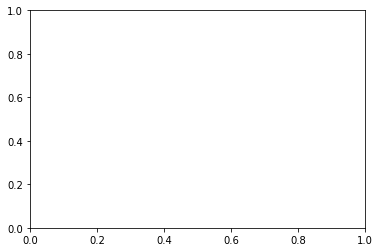

In [2658]:
plt.hist(np.log(alvaras_ml['TIPO_ALVAR']))

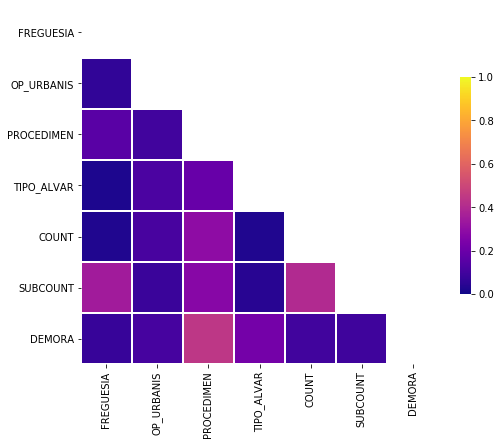

In [2584]:
# now every data is numerical I will compute the correlation matrix to remove colinearity features
corr = alvaras_ml.corr().abs()

# make a heatmap
f, ax = plt.subplots(figsize=(8, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='plasma', vmin=0, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

In [2585]:
X = alvaras_ml.drop('DEMORA', axis=1)
y = alvaras_ml['DEMORA']

In [2586]:
# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [2587]:
# make the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2588]:
# random forest regression
for i in range(1, 15):
    rfr = RandomForestRegressor(max_depth=i, random_state=42)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(i, mae, r2)

1 208.65740963031448 0.1929256142265089
2 201.77834771093066 0.23145830598031736
3 198.333335800295 0.257424761293087
4 196.5631078354271 0.27105797270497745
5 195.22549209663188 0.2836215624888162
6 193.22896975239888 0.29300219171444164
7 192.69940099059428 0.2961081879207308
8 192.3721373402221 0.2978189327370343
9 192.35877193857243 0.2966471322079888
10 192.25753726599945 0.2953016837042034
11 192.1663565833948 0.2941170861791439
12 191.88333450020804 0.2941808547178969
13 192.45417361788492 0.2879541387316569
14 192.62608980952635 0.28400841369239505


In [2589]:
rfr = RandomForestRegressor(max_depth=8, random_state=42)
rfr.fit(X_train, y_train)
score = rfr.score(X_train, y_train)
print('Train score:', score)
score = rfr.score(X_test, y_test)
print('Test score:', score)

y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
mse_train = mean_absolute_error(y_train, y_pred_train)
mse_test = mean_absolute_error(y_test, y_pred_test)

print('mae train', mse_train)
print('mae test', mse_test)

Train score: 0.387738085245118
Test score: 0.2978189327370343
mae train 176.1576762518673
mae test 192.3721373402221


In [2590]:
# cross validate the results of the random forest regressor
cv_rfr = cross_val_score(rfr, X, y, cv=6)
print(cv_rfr)
print(cv_rfr.mean())

[0.3010275  0.3040574  0.25811701 0.24659508 0.29931582 0.281551  ]
0.28177729979820515


# plotting based on permit delay

In [2629]:
freguesias_file = 'C:/Users/Zaca/Documents/Datasets/shapefiles/lisbon/freguesias.shp'
# city limits and subdivisions of lisbon
freguesias = gp.read_file(freguesias_file)
# freguesias
# project coordinates
freguesias = freguesias.to_crs('EPSG:3763')

# filepaths
buildings_file = 'C:/Users/Zaca/Documents/Datasets/portugal/gis_osm_buildings_a_free_1.shp'

# all buildings in portugal
buildings = gp.read_file(buildings_file)

# project coordinates
buildings = buildings.to_crs('EPSG:3763')

# buildings
# filter out all non-lisbon buildings
buildings = buildings[buildings['geometry'].centroid.within(freguesias.unary_union)]


# alvarás
# filter out entries that are only changes to a construction already in progress
alvaras_plot = alvaras[alvaras['OP_URBANIS'] != 'Alteração Durante a Execução da Obra']
alvaras_plot = alvaras_plot.to_crs('EPSG:3763')


C:\Users\Zaca\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

C:\Users\Zaca\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

C:\Users\Zaca\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

C:\User

In [2630]:
location = 'Santa Maria Maior'
location_buildings = buildings[buildings['geometry'].centroid.within(freguesias[freguesias['NOME'] == location]['geometry'].values[0])]
location_alvaras = alvaras_plot[alvaras_plot['FREGUESIA'] == location]
location_roads = roads[roads['geometry'].centroid.within(freguesias[freguesias['NOME'] == location]['geometry'].values[0])]

In [2631]:
location_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
310,4723892,5113,primary,Rua da Palma,None,F,0,0,F,F,"LINESTRING (-87206.732 -105119.555, -87186.068..."
413,5011480,5124,pedestrian,Rua dos Correeiros,None,B,0,0,F,F,"LINESTRING (-87305.089 -105941.588, -87328.682..."
414,5011481,5124,pedestrian,Rua Augusta,None,B,0,0,F,F,"LINESTRING (-87456.610 -105566.420, -87433.893..."
415,5011482,5122,residential,Rua dos Sapateiros,None,F,0,0,F,F,"LINESTRING (-87485.634 -105589.872, -87466.997..."
416,5011483,5115,tertiary,Rua Áurea,None,F,0,0,F,F,"LINESTRING (-87529.542 -105547.477, -87527.953..."
...,...,...,...,...,...,...,...,...,...,...,...
914730,748680788,5153,footway,None,None,B,0,0,F,F,"LINESTRING (-87380.516 -105545.327, -87382.138..."
918302,752932679,5155,steps,Arco do Rosário,None,B,0,0,F,F,"LINESTRING (-86670.908 -105893.897, -86672.423..."
918303,752932872,5124,pedestrian,None,None,B,0,0,F,F,"LINESTRING (-86630.103 -105900.558, -86646.305..."
933045,768595035,5115,tertiary,Largo do Terreirinho,None,B,0,0,F,F,"LINESTRING (-86963.822 -105232.760, -86955.660..."


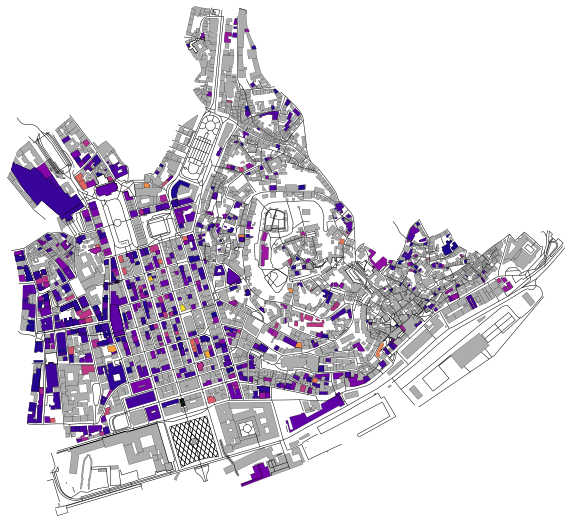

In [2635]:
base = location_buildings.plot(figsize=(10, 10), facecolor='#adadad', edgecolor='k', alpha=1, lw=.2)
location_alvaras.plot(ax=base, column='DEMORA', edgecolor='k', alpha=1, lw=.2, cmap='plasma')
location_roads.plot(ax=base, edgecolor='k', lw=.5)
base.axis('off');
base.margins(0)
base.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
#plt.savefig('figures/baixa_animation_end.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=False)

In [2595]:
alvaras['FREGUESIA'].value_counts()

Santa Maria Maior          881
Misericórdia               806
Santo António              661
Estrela                    531
Belém                      495
Arroios                    456
Avenidas Novas             420
Campo de Ourique           317
Alvalade                   272
Olivais                    270
São Vicente                192
Areeiro                    167
Benfica                    164
Campolide                  153
São Domingos de Benfica    138
Ajuda                      137
Lumiar                     128
Alcântara                  114
Penha de França            106
Carnide                     92
Parque das Nações           75
Beato                       74
Santa Clara                 71
Marvila                     64
Name: FREGUESIA, dtype: int64

In [2637]:
teste = processos.merge(alvaras, on='N_PROCESSO', how='left')

KeyError: 'N_PROCESSO'